Things to remember:

- Reversible computing


Binary addition 

0 + 0 = sum 0  carry 0

0+1 = sum 1 carry 0

1+0 = sum 1 carry 0

1+1 = sum 0 carry 1

1+1+1 = sum 1 carry 1

In [132]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt

what are the building blocks of reversibility

1. the reversible xor (sum component of half adder)
     it outputs 1 if both the inputs are different and outputs 0 if both of them are same
its basically, a sum operation when carry is not involved

CNOT gate in Quantum Gates performs the XOR operation and is reversible 


2. The reversible and 
     Classical AND is irreversible so to make it reversible we use toffoli gate

3. combining to a reversible half adder
     A classical half-adder takes two input bits, A and B, and produces two outputs: Sum (A XOR B) and Carry (A AND B). Now we can combine our reversible XOR and AND gates to create a reversible half-adder.

     for it to be fully reversible (reverse all operations and return the output qubits to their initial |0⟩ states) _-- Showing information recovery


In [133]:
a_val_xor = 1
b_val_xor = 0

qc_xor = QuantumCircuit(3,3)
print("Reversible XOR Circuit")
print(f"Classical Expectation: {a_val_xor} XOR {b_val_xor} = {a_val_xor ^ b_val_xor}")

Reversible XOR Circuit
Classical Expectation: 1 XOR 0 = 1


In [134]:

if a_val_xor == 1:
    qc_xor.x(0) 

if b_val_xor == 1:
    qc_xor.x(1)

In [135]:
qc_xor.barrier(label='Inputs Initialized')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

In [136]:
qc_xor.cx(0, 2) 
qc_xor.cx(1, 2)

The first cx(0, 2) copies A into Qubit 2.

The second cx(1, 2) XORs B into Qubit 2. Since Qubit 2 already held A, it now holds A XOR B.

In [137]:
qc_xor.barrier(label='XOR Computed')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

In [138]:
qc_xor.measure(0, 0) 
qc_xor.measure(1, 1) 
qc_xor.measure(2, 2) 


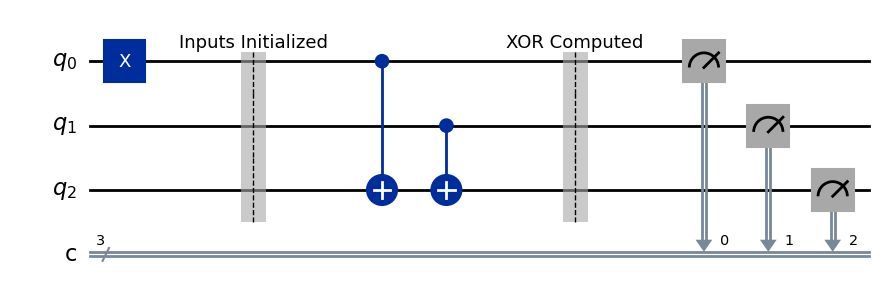

In [139]:
qc_xor.draw(output='mpl')

In [140]:
job = Aer.get_backend('qasm_simulator').run(qc_xor, shots=1024)
result = job.result()
counts_xor = result.get_counts()
print(counts_xor)

{'101': 1024}


In [141]:
from qiskit_ibm_runtime import QiskitRuntimeService

with open("ibmapi.txt", "r") as f:
    token = f.read().strip()

QiskitRuntimeService.save_account(
    token=token,
    instance="Practice",
    set_as_default=True,
    overwrite=True  # Allow overwriting the existing account
)

service = QiskitRuntimeService()

In [142]:
provider = service.backends()

In [143]:
provider

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]

In [144]:
for backend in provider:
    name = backend.name
    qubits = backend.num_qubits
    status = backend.status().operational
    pending_jobs = backend.status().pending_jobs
    print(f"Backend: {name}, Qubits: {qubits}, Operational: {status}, Pending Jobs: {pending_jobs}")

Backend: ibm_brisbane, Qubits: 127, Operational: True, Pending Jobs: 2059
Backend: ibm_torino, Qubits: 133, Operational: True, Pending Jobs: 420


In [145]:
from qiskit.visualization import plot_histogram

In [146]:
simulator = service.backend("ibm_torino")

In [147]:
from qiskit import transpile
transpiled_qc_xor = transpile(qc_xor, simulator)

In [148]:
from qiskit_ibm_runtime import Sampler
import time

sampler = Sampler(simulator)
# need to pass a list of circuits to `sampler.run()`, even if you have only one circuit.

job = sampler.run([transpiled_qc_xor], shots=1024)
while not job.done():
    print(f"Job is still running. Current status: {job.status()}")
    time.sleep(2)  # Wait for 10 seconds before checking again

job.wait_for_final_state()
print(f"Job completed with status: {job.status()}")

Job is still running. Current status: QUEUED
Job is still running. Current status: RUNNING
Job is still running. Current status: RUNNING
Job completed with status: DONE


In [149]:
result = job.result()

In [150]:
result[0].data

DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>))

In [151]:

bitvals = result[0].data.c  

counts_xor = bitvals.get_counts()

print(counts_xor)

{'101': 973, '001': 33, '100': 10, '111': 4, '000': 3, '011': 1}


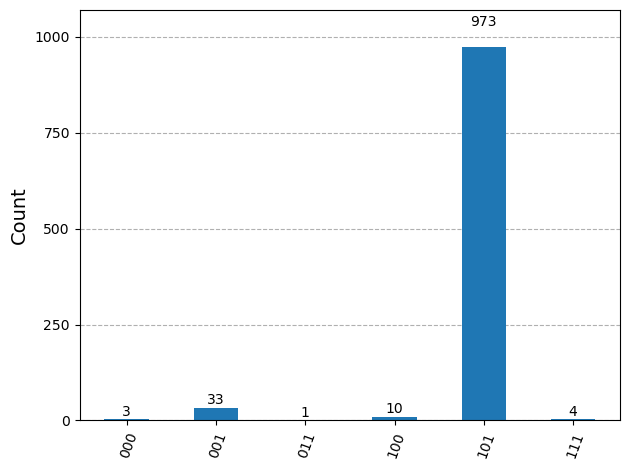

In [152]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
plot_histogram(counts_xor)

In [192]:
# Analyze the most frequent outcome (should be 100% for an ideal simulator)
most_frequent_xor = max(counts_xor.keys(), key=counts_xor.get)
measured_sum_xor = int(most_frequent_xor[0]) # Qubit 2 measurement (Sum)
measured_b_xor = int(most_frequent_xor[1])   # Qubit 1 measurement (B)
measured_a_xor = int(most_frequent_xor[2])   # Qubit 0 measurement (A)

print(f"Measured Outcome: {most_frequent_xor} (Qubit 2=Sum, Qubit 1=B, Qubit 0=A)")
print(f"  Measured A: {measured_a_xor} (Expected: {a_val_xor}) {'True' if measured_a_xor == a_val_xor else 'False'}")
print(f"  Measured B: {measured_b_xor} (Expected: {b_val_xor}) {'True' if measured_b_xor == b_val_xor else 'False'}")
print(f"  Measured Sum: {measured_sum_xor} (Expected: {a_val_xor ^ b_val_xor}) {'True' if measured_sum_xor == (a_val_xor ^ b_val_xor) else 'False'}")


Measured Outcome: 101 (Qubit 2=Sum, Qubit 1=B, Qubit 0=A)
  Measured A: 1 (Expected: 1) True
  Measured B: 0 (Expected: 0) True
  Measured Sum: 1 (Expected: 1) True


Crucial for Reversibility: Inputs A and B are preserved

Inputs A and B remain unchanged throughout the computation.

This is a key property of reversible gates like CNOT

Implementing reversible and gate

In [154]:
a_val_and = 1 
b_val_and = 1
qc_and = QuantumCircuit(3, 3)
print(f"Classical Expectation: {a_val_and} AND {b_val_and} = {a_val_and & b_val_and}")

Classical Expectation: 1 AND 1 = 1


In [155]:
if a_val_and == 1:
    qc_and.x(0)
if b_val_and == 1:
    qc_and.x(1)

In [156]:
qc_and.barrier(label='Inputs Initialized')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

In [157]:
qc_and.ccx(0, 1, 2)

In [158]:
qc_and.barrier(label='AND Computed')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

In [159]:
qc_and.measure(0, 0)
qc_and.measure(1, 1)
qc_and.measure(2, 2)

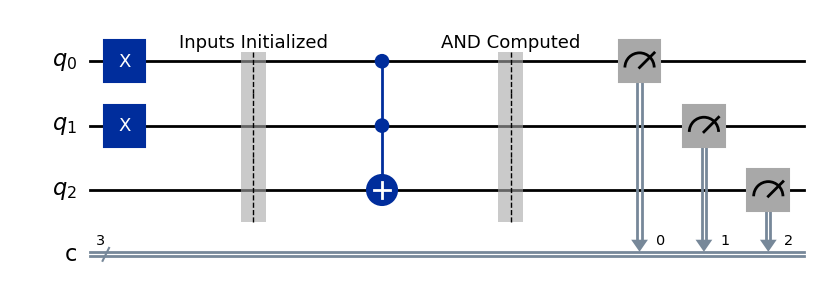

In [160]:
qc_and.draw(output='mpl', style='iqp')

In [161]:
job = Aer.get_backend('qasm_simulator').run(qc_and, shots=1024)
result = job.result()
counts_and = result.get_counts()
print(counts_and)

{'111': 1024}


In [162]:
transpiled_qc_and = transpile(qc_and, simulator)
sampler = Sampler(backend)

job = sampler.run([transpiled_qc_and], shots=1024)
while not job.done():
    print(f"Job is still running. Current status: {job.status()}")
    time.sleep(2)  # Wait for 10 seconds before checking again

job.wait_for_final_state()
print(f"Job completed with status: {job.status()}")

Job is still running. Current status: QUEUED
Job is still running. Current status: RUNNING
Job completed with status: DONE


In [163]:
result = job.result()
bitvals = result[0].data.c  

counts_and = bitvals.get_counts()

print(counts_and)

{'111': 870, '010': 38, '101': 51, '001': 19, '011': 21, '100': 3, '110': 18, '000': 4}


In [164]:
most_frequent_and = max(counts_and.keys(), key=counts_and.get)
measured_and_val = int(most_frequent_and[0]) 
measured_b_and = int(most_frequent_and[1])   
measured_a_and = int(most_frequent_and[2])   

In [191]:
print(f"Measured Outcome: {most_frequent_and} (Qubit 2=AND_Output, Qubit 1=B, Qubit 0=A)")
print(f"  Measured A: {measured_a_and} (Expected: {a_val_and}) {'True' if measured_a_and == a_val_and else 'False'}")
print(f"  Measured B: {measured_b_and} (Expected: {b_val_and}) {'True' if measured_b_and == b_val_and else 'False'}")
print(f"  Measured AND: {measured_and_val} (Expected: {a_val_and & b_val_and}) {'True' if measured_and_val == (a_val_and & b_val_and) else 'False'}")


Measured Outcome: 111 (Qubit 2=AND_Output, Qubit 1=B, Qubit 0=A)
  Measured A: 1 (Expected: 1) True
  Measured B: 1 (Expected: 1) True
  Measured AND: 1 (Expected: 1) True



Observation: Like CNOT, the Toffoli gate preserves its control inputs (A and B)

This is how we achieve reversible AND, avoiding information loss associated with classical AND

# 1-bit reversible half-adder

In [166]:
a_val_ha = 1
b_val_ha = 1

qc_ha = QuantumCircuit(4, 4)
print(f"Reversible Half-Adder")
print(f"Classical Expectation: Sum={a_val_ha ^ b_val_ha}, Carry={a_val_ha & b_val_ha}")


Reversible Half-Adder
Classical Expectation: Sum=0, Carry=1


In [167]:
if a_val_ha == 1: qc_ha.x(0)
if b_val_ha == 1: qc_ha.x(1)

In [168]:
qc_ha.barrier(label='Inputs Initialized')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>, <Qubit register=(4, "q"), index=3>), clbits=())

In [169]:
qc_ha.cx(0, 2)
qc_ha.cx(1, 2)

In [170]:
qc_ha.ccx(0, 1, 3)

In [171]:
qc_ha.barrier(label='Half-Adder Outputs')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>, <Qubit register=(4, "q"), index=3>), clbits=())

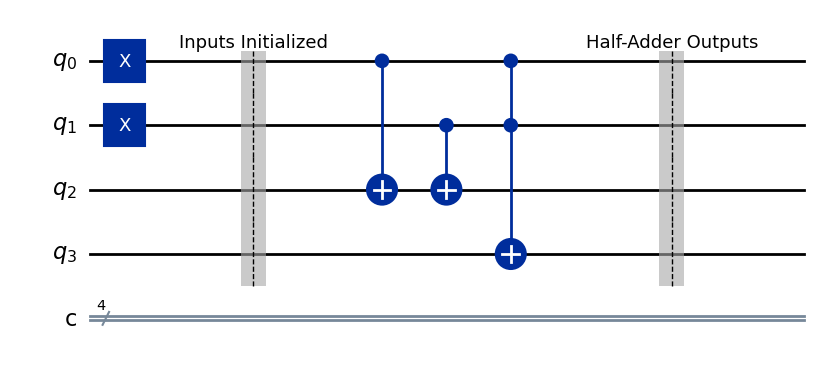

In [172]:
qc_ha.draw(output='mpl')

In [173]:
# undo carry computation
qc_ha.ccx(0, 1, 3)

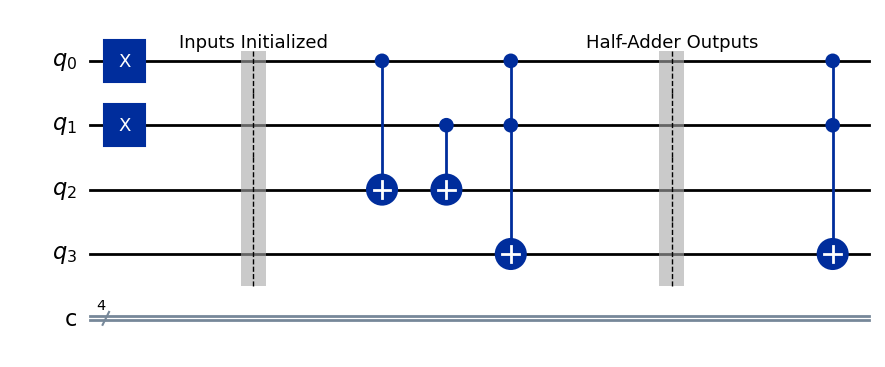

In [174]:
qc_ha.draw(output='mpl')

In [175]:
# Undo Sum computation in reverse order
qc_ha.cx(1, 2) 
qc_ha.cx(0, 2)


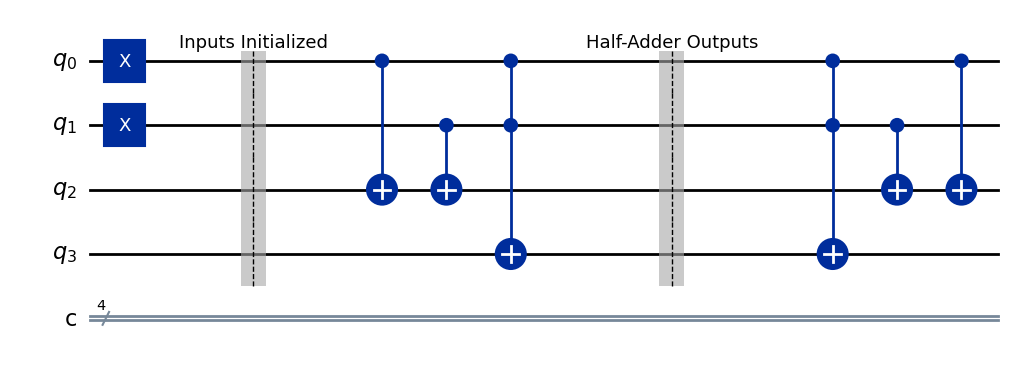

In [176]:
qc_ha.draw(output='mpl')

In [177]:
qc_ha.barrier(label='Uncomputed')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>, <Qubit register=(4, "q"), index=3>), clbits=())

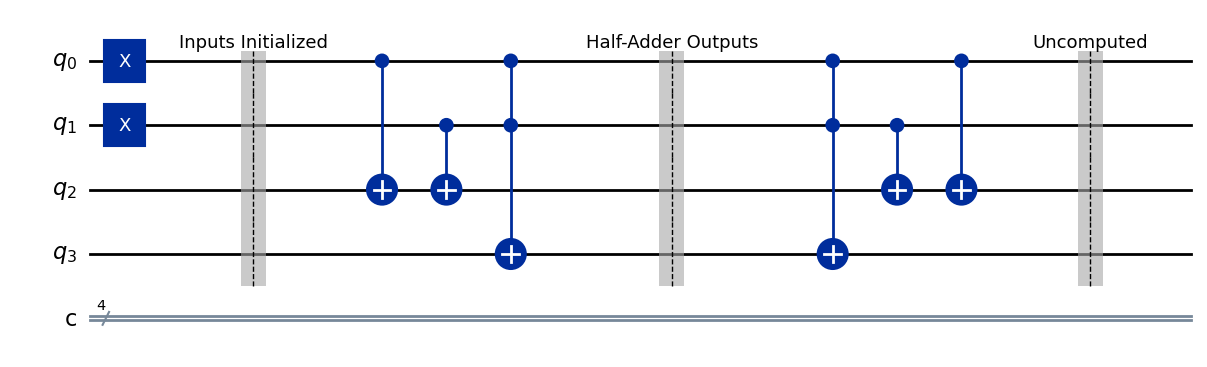

In [178]:
qc_ha.draw(output='mpl')

In [179]:
qc_ha.measure(0, 0) 
qc_ha.measure(1, 1) 
qc_ha.measure(2, 2) 
qc_ha.measure(3, 3) 

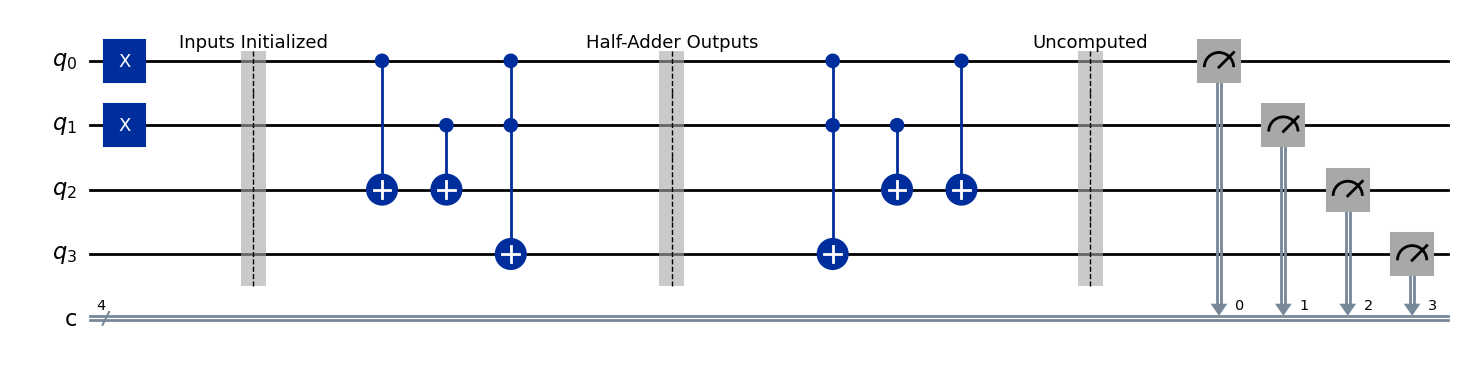

In [180]:
qc_ha.draw(output='mpl')

In [185]:
job = Aer.get_backend('qasm_simulator').run(qc_ha, shots=1024)
result = job.result()
counts_ha = result.get_counts()
print(counts_ha)

{'0011': 1024}


In [186]:
transpiled_qc_and = transpile(qc_ha, simulator)
sampler = Sampler(backend)

job = sampler.run([transpiled_qc_and], shots=1024)
while not job.done():
    print(f"Job is still running. Current status: {job.status()}")
    time.sleep(2)  # Wait for 10 seconds before checking again

job.wait_for_final_state()
print(f"Job completed with status: {job.status()}")

Job is still running. Current status: RUNNING
Job is still running. Current status: RUNNING
Job completed with status: DONE


In [187]:
result = job.result()
bitvals = result[0].data.c  

counts_ha = bitvals.get_counts()

print(counts_ha)

{'0011': 736, '1110': 18, '0110': 42, '0111': 39, '1000': 11, '1100': 2, '0010': 30, '0101': 27, '0001': 44, '0100': 11, '1011': 17, '1111': 7, '1101': 16, '0000': 13, '1001': 6, '1010': 5}


In [188]:
most_frequent_ha = max(counts_ha.keys(), key=counts_ha.get)
measured_carry_cleared = int(most_frequent_ha[0]) # Qubit 3 (Carry)
measured_sum_cleared = int(most_frequent_ha[1])   # Qubit 2 (Sum)
measured_b_recovered = int(most_frequent_ha[2])   # Qubit 1 (B)
measured_a_recovered = int(most_frequent_ha[3])   # Qubit 0 (A)

In [190]:
print(f"Measured Outcome after Uncomputation: {most_frequent_ha} (C3=Carry, C2=Sum, C1=B, C0=A)")
print(f"  Recovered A: {measured_a_recovered} (Expected: {a_val_ha}) {'True' if measured_a_recovered == a_val_ha else 'False'}")
print(f"  Recovered B: {measured_b_recovered} (Expected: {b_val_ha}) {'True' if measured_b_recovered == b_val_ha else 'False'}")
print(f"  Sum Cleared: {measured_sum_cleared} (Expected: 0) {'True' if measured_sum_cleared == 0 else 'False'}")
print(f"  Carry Cleared: {measured_carry_cleared} (Expected: 0) {'True' if measured_carry_cleared == 0 else 'False'}")


Measured Outcome after Uncomputation: 0011 (C3=Carry, C2=Sum, C1=B, C0=A)
  Recovered A: 1 (Expected: 1) True
  Recovered B: 1 (Expected: 1) True
  Sum Cleared: 0 (Expected: 0) True
  Carry Cleared: 0 (Expected: 0) True
